In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path

In [2]:
# Load options data, original format
df_option = pd.read_parquet(os.path.join(data_path, 'SPY_options.parquet'))
df_option = df_option[df_option['EXPIRE_DATE'] != '2015-12-19']
df_option = df_option[df_option['EXPIRE_DATE'] != '2018-12-23']

In [3]:
# Load SPY price data
df_stock = pd.read_pickle(os.path.join(data_path, 'spy_1d.pkl'))
df_stock['ts'] = pd.to_datetime(df_stock['ts'].dt.date)
df_stock = df_stock[(df_stock['ts']>='2010-01-01')&(df_stock['ts']<='2022-12-31')]

In [4]:
# filter ATM option

atm_df = df_option.dropna(subset=['C_LAST', 'P_LAST']) # clean NaN value
atm_df = atm_df[atm_df['STRIKE_DISTANCE_PCT'] <= 0.01] # define threshold for ATM
atm_df = atm_df[(atm_df['DTE']>=10) &(atm_df['DTE']<=30)] # filter for expiry date

In [5]:
r = 0.03 # or can be pull from other data source

# cal delta_neutral for each option price using put call parity
atm_df['delta_neutral_price'] = atm_df['STRIKE'] + np.exp(r * atm_df['DTE']/365) * (atm_df['C_LAST'] - atm_df['P_LAST'])
# take average group by each quote date
dn_price = atm_df.groupby('QUOTE_DATE')['delta_neutral_price'].mean().reset_index()


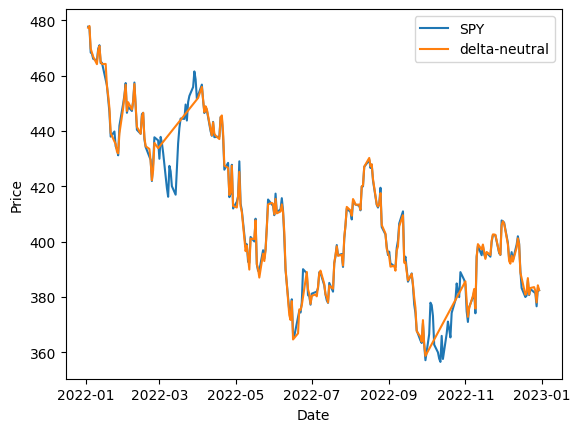

In [14]:
# plot spy and delta neutral price
# earliest data: 2010, latest data: 2022
starting_date = '2022-01-01'
ending_date = '2022-12-31'

plt.plot(df_stock[(df_stock['ts']>=starting_date)&(df_stock['ts']<=ending_date)]['ts'], df_stock[(df_stock['ts']>=starting_date)&(df_stock['ts']<=ending_date)]['close_price'],label='SPY')
plt.plot(dn_price[(dn_price['QUOTE_DATE']>=starting_date)&(dn_price['QUOTE_DATE']<=ending_date)]['QUOTE_DATE'], dn_price[(dn_price['QUOTE_DATE']>=starting_date)&(dn_price['QUOTE_DATE']<=ending_date)]['delta_neutral_price'],label='delta-neutral')

plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()